# The Greeks under the Heston Model

### Main Reference

**Valuing European Option Using the Heston Model in QuantLib Python**

http://gouthamanbalaraman.com/blog/valuing-european-option-heston-model-quantLib.html

- kappa = 0.1   mean reversion strength 
- sigma = 0.1   vol of volatility 
- rho = -0.75   correlation between the asset price and its variance
- vol = 0.2     vol of the underlying stock (known to be 20%)
- v0 = vol^2 = 0.04   the spot variance 
- theta = v0    the mean reversion variance

### Some Other References

- QuantLib: setting up QuantLib-Python and pricing an option: https://www.quantopia.net/quantlib-setting-up-quantlib-python-and-pricing-an-option/
- Introducing QuantLib: Black-Scholes and the Greeks: https://mhittesdorf.wordpress.com/2013/07/29/introducing-quantlib-black-scholes-and-the-greeks/
- QuantLib, the Greeks and other useful option-related values: https://quantcorner.wordpress.com/2011/02/06/quantlib-the-greeks-and-other-useful-option-related-values/
- Heston Model: Formula, Assumptions, Limitations: https://blog.quantinsti.com/heston-model/

In [1]:
#!pip install QuantLib-Python

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import QuantLib as ql

In [3]:
# option parameters
strike_price = 1.00
option_type = ql.Option.Call
maturity_date = ql.Date(31, 12, 2020)
day_count = ql.Actual365Fixed()
calendar = ql.UnitedStates()

# construct the European Option
payoff = ql.PlainVanillaPayoff(option_type, strike_price)
exercise = ql.EuropeanExercise(maturity_date)
european_option = ql.VanillaOption(payoff, exercise)

# parameters for Heston
kappa = 0.1  # mean reversion strength
sigma = 0.1  # vol of vol
rho = -0.75  # corr between asset price and var
vol = 0.20   # historical vols for the stock
v0 = vol*vol # spot variance
theta = v0   # mean reversion variance

In [4]:
def heston_value(calculation_date, v0, spot_price):
    # set the evaluation date
    ql.Settings.instance().evaluationDate = calculation_date

    # construct the yield curve
    dividend_rate =  0
    risk_free_rate = 0
    flat_ts = ql.YieldTermStructureHandle(
        ql.FlatForward(calculation_date, risk_free_rate, day_count)
    )
    dividend_yield = ql.YieldTermStructureHandle(
        ql.FlatForward(calculation_date, dividend_rate, day_count)
    )

    # set the spot price
    spot_handle = ql.QuoteHandle(
        ql.SimpleQuote(spot_price)
    )
    
    # calculate option price
    heston_process = ql.HestonProcess(
    flat_ts, dividend_yield, spot_handle,
    v0, kappa, theta, sigma, rho
    )

    engine = ql.AnalyticHestonEngine(ql.HestonModel(heston_process),0.01, 1000)
    european_option.setPricingEngine(engine)
    h_price = european_option.NPV()
    
    return h_price

### Calculate the Greeks numerically
Use central finite difference

In [5]:
v0_delta = 0.001
spot_delta = 0.0005

def calc_greeks(calculation_date, v0, spot_price):

    v0_plus  = v0 + v0_delta
    v0_minus = v0 - v0_delta
    spot_price_plus  = spot_price + spot_delta
    spot_price_minus = spot_price - spot_delta
    
    p_curr = heston_value(calculation_date, v0, spot_price)
    
    p_vega_plus  = heston_value(calculation_date, v0_plus,  spot_price)
    p_vega_minus = heston_value(calculation_date, v0_minus, spot_price)
    
    p_delta_plus  = heston_value(calculation_date, v0, spot_price_plus)
    p_delta_minus = heston_value(calculation_date, v0, spot_price_minus)
    
    delta = (p_delta_plus - p_delta_minus) / spot_delta * 2
    vega = (p_vega_plus - p_vega_minus) / v0_delta * 2
    
    return [delta, vega]



In [6]:
calculation_date = ql.Date(1, 10, 2020)

v0_grid   = np.linspace(0.02, 0.2, 50)
spot_grid = np.linspace(0.20, 2.0, 50)

v0_size   = len(v0_grid)
spot_size = len(spot_grid)

delta_map = np.zeros((v0_size, spot_size))
vega_map  = np.zeros((v0_size, spot_size))

v0 = 0.04
spot_price = 1.0

for i in range(v0_size):
    for j in range(spot_size):
        [d, v] = calc_greeks(calculation_date, v0_grid[i], spot_grid[j])
        delta_map[i][j] = d * (d>0)
        vega_map[i][j] = v * (v>0)

In [7]:
def smooth_delta(delta_map_input):
    delta_map = np.copy(delta_map_input)
    
    fig = plt.figure(figsize=(16,8))
    ax = fig.add_subplot(121, projection='3d')
    X, Y = np.meshgrid(spot_grid[:], v0_grid[:])
    Z = delta_map[:,:]
    ax.plot_surface(X, Y, Z, cmap=cm.coolwarm)
    ax.set_zlim(0, 5)

    (d1, d2) = delta_map.shape
    
    for i in range(1, d1):
        monotone = delta_map[i,:] < (delta_map[i-1,:] * 1.01)
        delta_map[i,:] = delta_map[i,:] * (monotone) + delta_map[i-1,:] * (1 - monotone) 
    for j in range(1, d2):
        monotone = delta_map[:,j] > (delta_map[:,j-1] * 0.99)
        delta_map[:,j] = delta_map[:,j] * (monotone) + delta_map[:,j-1] * (1 - monotone)
    #delta_map[1,:] = delta_map_s[2,:]
    delta_map[0,:] = delta_map[1,:]
    
    ax = fig.add_subplot(122, projection='3d')
    X, Y = np.meshgrid(spot_grid[:], v0_grid[:])
    Z = delta_map[:,:]
    ax.plot_surface(X, Y, Z, cmap=cm.coolwarm)
    
    return delta_map

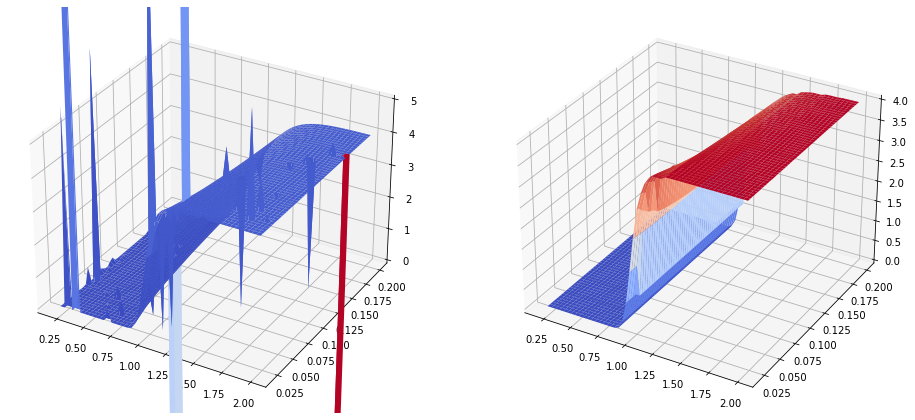

In [8]:
delta_map_s = smooth_delta(delta_map);

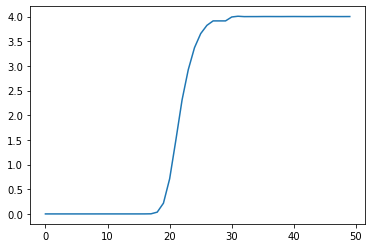

In [9]:
plt.plot(delta_map_s[2,:])

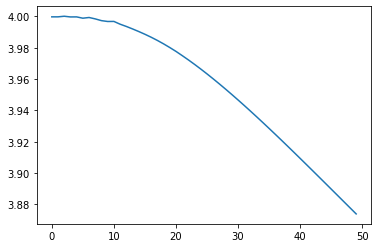

In [10]:
plt.plot(delta_map_s[:,35])

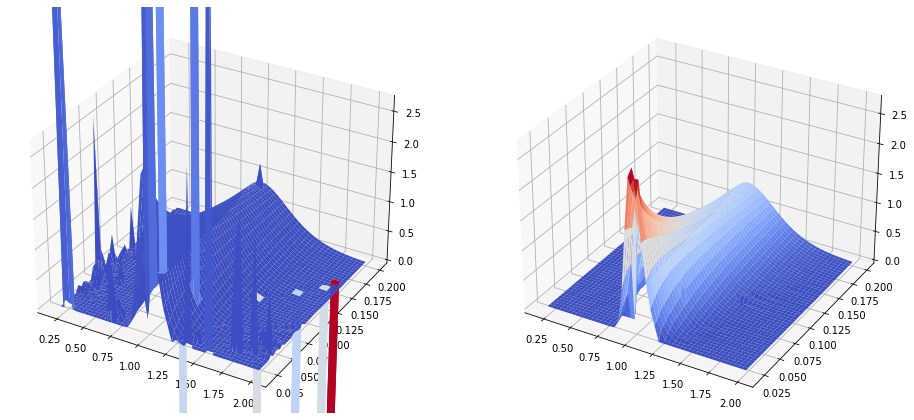

In [11]:
def smooth_vega(vega_map_input, strike):
    
    vega_map = np.copy(vega_map_input)
    
    fig = plt.figure(figsize=(16,8))
    ax = fig.add_subplot(121, projection='3d')
    X, Y = np.meshgrid(spot_grid[:], v0_grid[:])
    Z = vega_map[:,:]
    ax.plot_surface(X, Y, Z, cmap=cm.coolwarm)
    ax.set_zlim(0, 2.7)

    (d1, d2) = vega_map.shape
    
    ind_left = np.sum(spot_grid < strike_price)
    ind_right = np.sum(spot_grid > strike_price)
    
    for j in range(d2-ind_right+1,d2):
        monotone = vega_map[:,j] < (vega_map[:,j-1] * 1.01)
        vega_map[:,j] = vega_map[:,j] * (monotone) + vega_map[:,j-1] * (1 - monotone)   
    for j in np.arange(ind_left-2, -1, -1):
        monotone = vega_map[:,j] < (vega_map[:,j+1] * 1.01)
        vega_map[:,j] = vega_map[:,j] * (monotone) + vega_map[:,j+1] * (1 - monotone)
    
    ax = fig.add_subplot(122, projection='3d')
    X, Y = np.meshgrid(spot_grid[:], v0_grid[:])
    Z = vega_map[:,:]
    ax.plot_surface(X, Y, Z, cmap=cm.coolwarm)
    
    return vega_map

vega_map_s = smooth_vega(vega_map, strike_price);

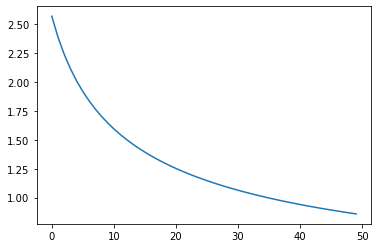

In [12]:
plt.plot(vega_map_s[:,21])

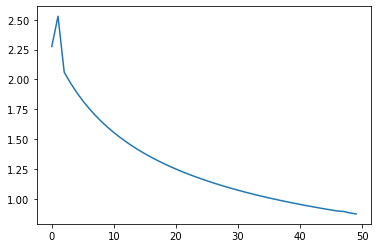

In [13]:
plt.plot(vega_map_s[:,23])

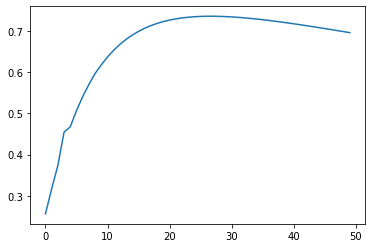

In [14]:
plt.plot(vega_map_s[:,27])